# Portfolio Risk Assessment and 95% VAR

*Goal*: Quantify the daily risk of losing money in a simple four-stock portfolio

Key Concepts:
- Log returns: how prices change day-to-day
- Summary Statistics: average, variability, skewness, tail-heaviness
- Value at Risk(VAR): threshold loss you won't exceed 95% of the time
- Confidence Intervals: ranges where a true parameter likely lie
- Hypothesis Testing: checking if the average return is different from zero

In [ ]:
!pip install --quiet yfinance

*yfinance* : A Python library to easily download financial market data from Yahoo Finance.

In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time

sns.set_style("whitegrid")

Fetching data for four stocks using yfinance. The four stocks are Apple, Microsft, Google and Amazon

In [ ]:
ticker = ['AAPL','MSFT','GOOGL','AMZN']
weights = np.array([0.25,0.25,0.25,0.25])

start = dt.datetime(2020,1,1) # Start date of fetching data
end = dt.datetime.today() # End date

price = pd.DataFrame(index=pd.date_range(start,end))

for t in ticker:
  print(f"fetching{ticker}",end = "")
  try:
    # fetching the data
    df = yf.Ticker(ticker).history(start=start.strftime("%Y-%m-%d"),end = end.strftime("%Y-%m-%d"),auto_adjust=True,)
    series = df['Close']
    print("Y finance ",end="")
  except Exception as e:
    print(f"X yfinance ({e}); falling back to Stooq")
    df2 = pdr.DataReader(ticker,'stooq',start,end)
    df2 = df2.sort_index()
    series= df2['Close']

  price[ticker] = series
  time.sleep(1)

price = price.dropna(how='all').ffill().bfill()
price.head()

fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq


,AAPL,MSFT,GOOGL,AMZN
2020-01-02,72.7161,153.613,68.1868,94.9005
2020-01-03,72.0115,151.726,67.8302,93.7485
2020-01-06,72.5811,152.118,69.6381,95.1440
2020-01-07,72.2432,150.710,69.5035,95.3430
2020-01-08,73.4042,153.142,69.9983,94.5985


In [ ]:
price.tail()

,AAPL,MSFT,GOOGL,AMZN
2025-05-16,211.26,454.27,166.19,205.59
2025-05-19,208.78,458.87,166.54,206.16
2025-05-20,206.86,458.17,163.98,204.07
2025-05-21,202.09,452.57,168.56,201.12
2025-05-22,201.36,454.86,170.87,203.10


In [ ]:
# Calculate log returns of the stocks
logR=np.log(price /price.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


Logarithmic returns (log returns) measure the percentage change in stock prices using natural logs.

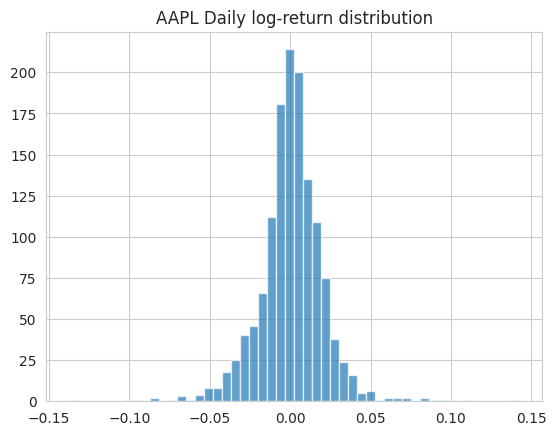

In [ ]:
# Plotting the histogram of AAPL
logR['AAPL'].hist(bins=50,alpha=0.7)
plt.title("AAPL Daily log-return distribution")
plt.show()

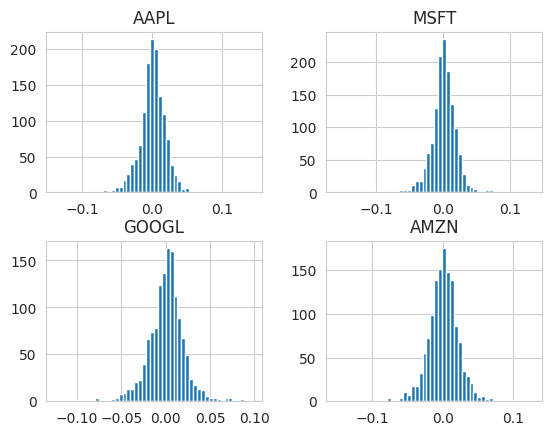

In [ ]:
# Plotting the histograms of all
logR.hist(bins = 50)
plt.show()

Mean: average daily return

Variance: how much returns vary

Skewness: asymmetry (positive skew → fat right tail)

Kurtosis: tail-heaviness (high kurtosis → more extreme days)

In [ ]:
summary=pd.DataFrame({
    'Mean': logR.mean(),
    'Variance': logR.var(),
    'Skew': logR.skew(),
    'Kurtosis': logR.kurtosis()
})
summary

,Mean,Variance,Skew,Kurtosis
AAPL,0.000752,0.000425,0.020390,6.226807
MSFT,0.000802,0.000372,-0.164616,7.430717
GOOGL,0.000678,0.000431,-0.227661,3.636135
AMZN,0.000562,0.000524,-0.069501,4.160446


Mean (≈0.05–0.08%): On average each stock’s daily return was very small—about a few‐tenths of a percent gain per day.**bold text**

Variance (≈0.0004): Typical daily swings are around √0.0004 ≃ 2%, so most days see moves of a couple percent.

Skewness (near zero or slightly negative): Returns are roughly symmetric, with a small tendency toward bigger down‐moves than up‐moves.

Kurtosis (>3): All four have “fat tails,” meaning they experience more extreme one‐day jumps or crashes than a normal bell curve would predict.

Normal Fit

In [ ]:
# Calculate U and std deviation
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof=1)
# 95% CI for mean under Normal: μ ± z*·σ/√N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),
              mu_norm + z95*sigma_norm/np.sqrt(N))


# 95% CI for σ via Chi-square:
df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025,0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal fit:")
print(f"  μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"  σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal fit:
  μ = 0.00070, 95% CI (np.float64(0.00014135581013294892), np.float64(0.0012558400131748955))
  σ = 0.02092, 95% CI (np.float64(0.02053681862658147), np.float64(0.02132521057520147))


In [ ]:
returns_flat=logR.stack().values
returns_flat

array([-0.00973699, -0.01236019, -0.00524347, ...,  0.00504723,
        0.01361126,  0.00979672])

Finding mean and sigma with t distribution

In [ ]:
# Fit student's t
df_t,mu_t,sigma_t=stats.t.fit(returns_flat)
print(df_t,mu_t,sigma_t)

3.6546646101861917 0.0010493773461387728 0.014469386072158637


Step 1:Bootstrapping Setup


We take 1,000 random samples from the dataset to generate multiple estimates. This step is crucial because it reduces the impact of outliers and helps us make more reliable and confident conclusions from the data.

Fit t-distribution for each resample and store estimates for later CI calculation.

In [ ]:
B=1000
estimates=np.array([
    stats.t.fit(np.random.choice(returns_flat,size=N,replace=True))
    for _ in range(B)
])

In [ ]:
ci_mu_t=np.percentile(estimates[:,1],[2.5,97.5])
ci_sigma_t=np.percentile(estimates[:,2],[2.5,97.5])
print("\nStudent’s t fit:")
print(f"  df = {df_t:.1f}, μ = {mu_t:.5f},  σ = {sigma_t:.5f}")
print(f"  95% CI for μ (bootstrap): {ci_mu_t}")
print(f"  95% CI for σ (bootstrap): {ci_sigma_t}")


Student’s t fit:
  df = 3.7, μ = 0.00105,  σ = 0.01447
  95% CI for μ (bootstrap): [0.00057743 0.00148452]
  95% CI for σ (bootstrap): [0.0139782 0.0149552]


## VAR With normal distribution

### Portfolio Returns
Multiplying the log returns of the stocks with their weights we get the portfolio returns

In [ ]:
portR=logR.dot(weights)
portR

,0
2020-01-03,-0.009888
2020-01-06,0.012885
2020-01-07,-0.003453
2020-01-08,0.007801
2020-01-09,0.012131
...,...
2025-05-16,0.004292
2025-05-19,0.000785
2025-05-20,-0.009112
2025-05-21,-0.005660


Z_score

In [ ]:
mu_p=portR.mean()
sigma_p=portR.std(ddof=1)
print(mu_p,sigma_p )

0.0006985979116539223 0.01816307307599588


In [ ]:
z05=stats.norm.ppf(0.05)
#VaR with 95%
vaR_norm=-(mu_p+sigma_p*z05)
print(vaR_norm)

0.02917699871398255


With 95% confidence, losses exceeding this VaR value are not expected within one day.

## Parametric VaR  - Students's t

- Fits a Student's t distribution to the return data.  
- This approach is more conservative for fat-tailed distributions, accounting for heavier tails and increased risk.

In [ ]:
# Fit student's t
df_t,mu_t,sigma_t=stats.t.fit(returns_flat)
print(df_t,mu_t,sigma_t)

t05=stats.t.ppf(0.05,df_t)
vaR_t=-(mu_t+sigma_t*t05)*1
print(vaR_t)

3.6546646101861917 0.0010493773461387728 0.014469386072158637
0.03065396154289155


## Historical Method(non-parametric):

Calculates VaR (historical) as the **negative 5th percentile** of actual return data.

This method makes **no distributional assumptions** and is based solely on historical losses.


In [ ]:
hist_var=-np.percentile(portR,5)
print(hist_var)

0.028926594256303912


In [ ]:
print("1-Day 95% VaR:")
print(f"  Parametric (Normal):       {vaR_norm:.5f}")
print(f"  Parametric (Student’s t):  {vaR_t:.5f}")
print(f"  Historical (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
  Parametric (Normal):       0.02918
  Parametric (Student’s t):  0.03065
  Historical (5th percentile): 0.02893


### Hypothesis Test on Portfolio Return

- **Null Hypothesis (H₀):** The portfolio’s mean return is zero.  
- A t-test is used to determine if the mean return significantly differs from zero.  
- If the p-value is less than 0.05, we reject H₀, indicating that the mean return is likely non-zero.


In [ ]:
t_stat,p_val=stats.ttest_1samp(portR,0.0)

In [ ]:
print("One-sample t-test on portfolio daily returns:")
print(f"  t-statistic = {t_stat:.3f},  p-value = {p_val}")

One-sample t-test on portfolio daily returns:
  t-statistic = 1.415,  p-value = 0.15721184414606912


In [ ]:
if p_val<0.05:
  print("Reject the null hypothesis")
else:
  print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


Correlation matrix

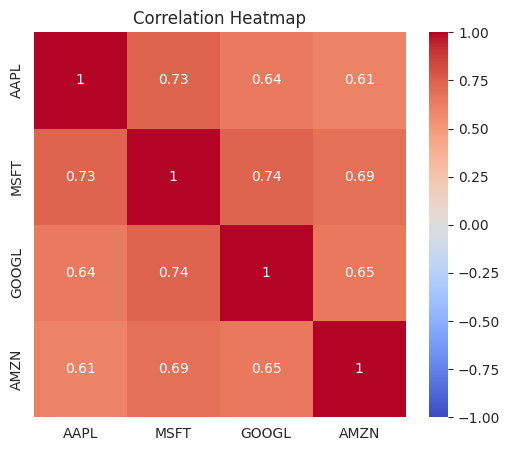

Weighted avg sigma: 0.0209
Actual Portfolio: 0.0182
Diversification benefit: 0.0027


In [ ]:
#7. correlation and diversification

#a)correlation heatmap
corr=logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr,annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#b)
sigma_i = logR.std()
sigma_weighted = np.dot(weights, sigma_i)
sigma_portfolio = sigma_p
print(f"Weighted avg sigma: {sigma_weighted:.4f}")
print(f"Actual Portfolio: {sigma_portfolio:.4f}")
print(f"Diversification benefit: {sigma_weighted-sigma_portfolio:.4f}")


- A lower portfolio standard deviation indicates improved diversification.

## Cumulative Returns & Portfolio Growth

- `cum_ret`: Computes the cumulative return for each individual asset.  
- `cum_port`: Calculates the cumulative portfolio return by compounding the daily returns over time.



In [ ]:
cum_ret=(price/price.iloc[0]).prod(axis=1)

In [ ]:
cum_port=(portR+1).cumprod()
cum_port

,0
2020-01-03,0.990112
2020-01-06,1.002869
2020-01-07,0.999406
2020-01-08,1.007203
2020-01-09,1.019421
...,...
2025-05-16,2.074619
2025-05-19,2.076247
2025-05-20,2.057330
2025-05-21,2.045685


- **Rolling Max:** Tracks the highest portfolio value reached up to each point in time.  
- **Drawdown:** Represents the percentage decline from the peak value.  
- **Max Drawdown (MDD):** The largest drop from a peak observed during the period.  
- **End Date:** The date when the maximum drawdown occurred.  


In [ ]:
rolling_max=cum_port.cummax()
rolling_max

,0
2020-01-03,0.990112
2020-01-06,1.002869
2020-01-07,1.002869
2020-01-08,1.007203
2020-01-09,1.019421
...,...
2025-05-16,2.380495
2025-05-19,2.380495
2025-05-20,2.380495
2025-05-21,2.380495


In [ ]:
drawdown=(cum_port-rolling_max)/rolling_max
drawdown

,0
2020-01-03,0.000000
2020-01-06,0.000000
2020-01-07,-0.003453
2020-01-08,0.000000
2020-01-09,0.000000
...,...
2025-05-16,-0.128492
2025-05-19,-0.127809
2025-05-20,-0.135755
2025-05-21,-0.140647


In [ ]:
max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

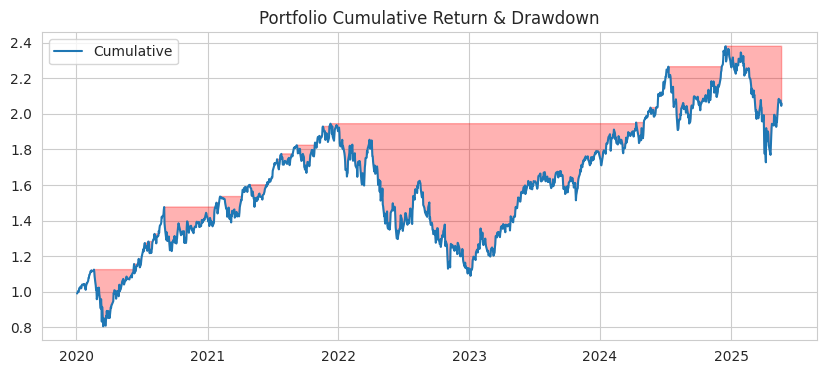

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Cumulative')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where=drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

Line chart displays the cumulative portfolio value over time.

Red shaded regions highlight periods of portfolio drawdowns.


## Expected Shortfall (ES)

Expected Shortfall (ES), or Conditional VaR, measures the **average loss in the worst-case scenarios**, beyond the Value at Risk (VaR) threshold.

- It gives the **mean loss** when losses exceed the VaR level.
- More informative than VaR for understanding **tail risk**.

In [ ]:
alpha=0.5 ## ES at beyond 95%
#hisorical
ES_historical=-portR[portR<=np.percentile(portR,5)].mean()

##normal method
ES_norm=(mu_p+sigma_p*stats.norm.pdf(z05)/alpha)


print(f"Historical ES (95%): {ES_historical:.5f}")
print(f"Parametric Normal ES (95%): {ES_norm:.5f}")

Historical ES (95%): 0.04230
Parametric Normal ES (95%): 0.00445


## VaR Backtesting

In [ ]:
var_series=-(portR.rolling(1).mean()+portR.rolling(1).std()*z05)
#Normal distribution vaR
exc=portR<-vaR_norm
num_exc=exc.sum()
total=len(portR)
print(num_exc/total)

0.04948301329394387


In [ ]:
portR.rolling(1).mean()

,0
2020-01-03,-0.009888
2020-01-06,0.012885
2020-01-07,-0.003453
2020-01-08,0.007801
2020-01-09,0.012131
...,...
2025-05-16,0.004292
2025-05-19,0.000785
2025-05-20,-0.009112
2025-05-21,-0.005660


## Rolling Historical VaR Plot
Applies a 60-day rolling window to compute dynamic historical VaR.

Compares the rolling 5th percentile of returns with the fixed parametric VaR.


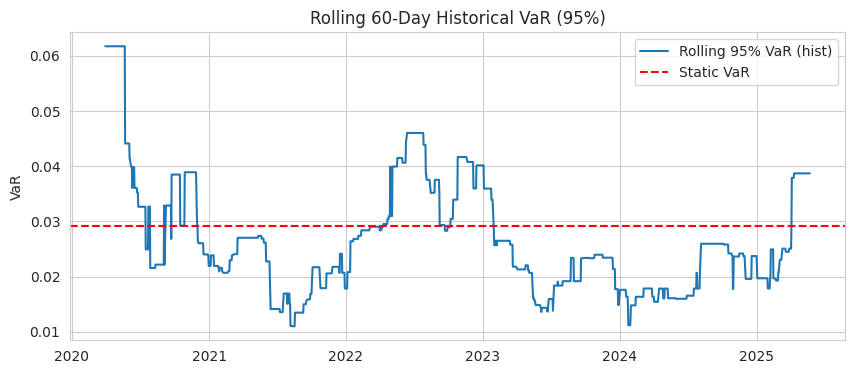

In [ ]:
# Rolling 60-day VaR
window = 60
roll_var = portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(vaR_norm, color='red', linestyle='--', label='Static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

## Normality Test of Portfolio Returns (Jarque-Bera Test)

The **Jarque-Bera Test** assesses whether the returns follow a normal distribution.

- **Null Hypothesis (H₀):** Returns are normally distributed.
- **Interpretation:**  
  - If **p-value < 0.05**, reject H₀ → returns are **not normally distributed**, which may be problematic for models like **parametric Value at Risk (VaR)**.


In [ ]:
jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p}")
if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")

JB statistic = 1191.65, p-value = 1.7215493309912836e-259
Reject normality at 5% level.


## Conclusion
- Jarque-Bera test shows stock and portfolio returns are non-normal with fat tails (more frequent extreme moves).
- Average daily returns are small; typical daily volatility is around 2%.
- Diversification reduces portfolio risk compared to individual stocks.
- Normality-based risk models (e.g., Normal VaR) may underestimate large losses.
- Risk measures that account for fat tails (historical VaR, Student’s t VaR, Expected Shortfall) are more appropriate for this portfolio.


